# Embedding

Tanto el gpt-2 como el music transformer empiezan codificando el input por medio de 2 embeddings. http://jalammar.github.io/illustrated-gpt2/

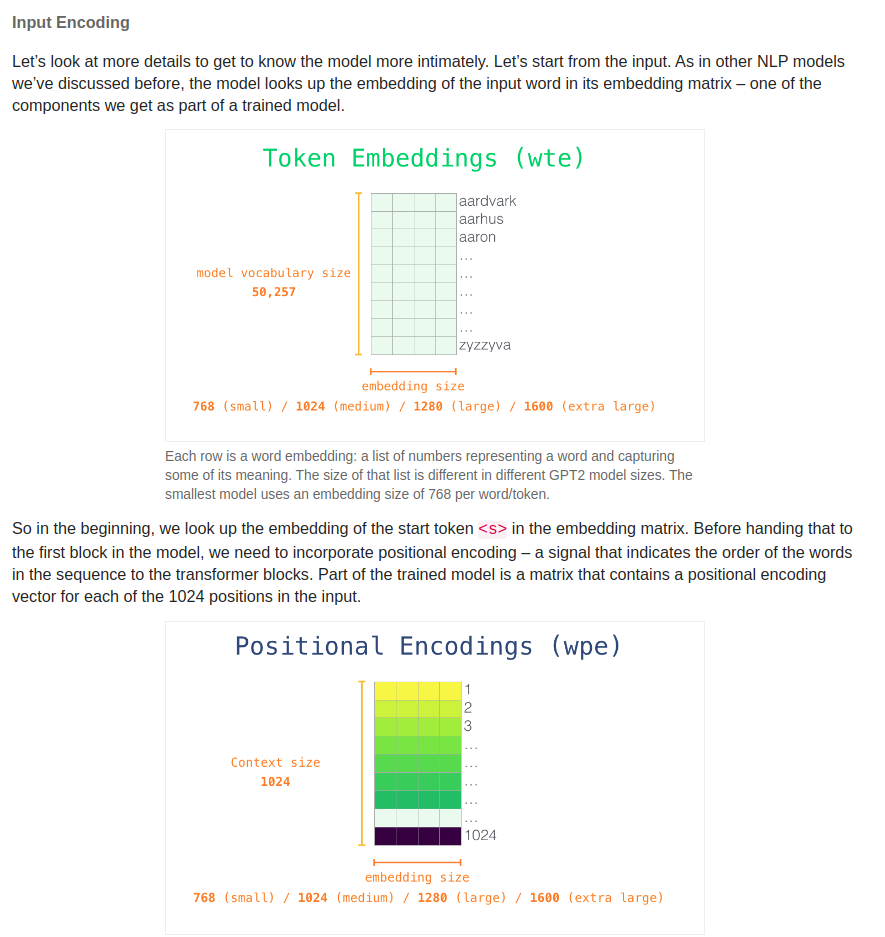

Aquí podemos ver como en la librería huggingface se inicializa un modelo GPT-2.

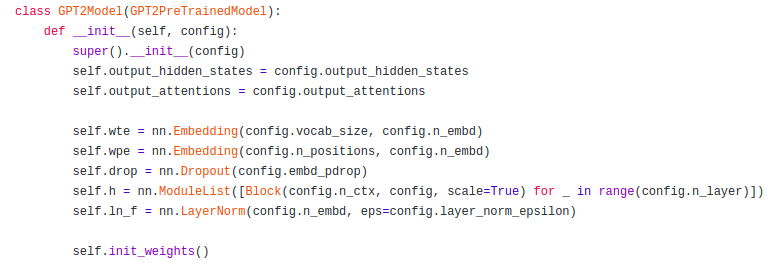

Sin embargo, como huggingface se especializa en modelar lenguaje, no podemos usar el modelo pre entrenado, ni tampoco el embedding por defecto. Debemos entrenar uno nuevo.

Queda la duda de si el embedding es entrenado por gtp2 o viene pre entrenado. En este notebook se entrena un embedding para los tokens musicales.

# Performance notation loading

In [3]:
!find "./maestro_encoded" -name "*.txt" > maestro_encoded_paths.txt

In [13]:
with open("maestro_encoded_paths.txt") as f:
    paths = list(map(lambda x: x.strip(), f.readlines()))

In [7]:
def read_file(path):
    with open(path) as f:
        tokens = f.readline().split(',')
    return tokens

In [8]:
vocabulary = read_file("vocabulary.txt")
vocabulary

['TIMESHIFT<855>',
 'NOTE-ON<48>',
 'TIMESHIFT<761>',
 'TIMESHIFT<1022>',
 'NOTE-ON<71>',
 'SET-VELOCITY<110>',
 'TIMESHIFT<1021>',
 'NOTE-ON<36>',
 'TIMESHIFT<53>',
 'TIMESHIFT<45>',
 'NOTE-OFF<60>',
 'TIMESHIFT<143>',
 'TIMESHIFT<789>',
 'TIMESHIFT<447>',
 'TIMESHIFT<412>',
 'TIMESHIFT<594>',
 'SET-VELOCITY<106>',
 'TIMESHIFT<275>',
 'NOTE-ON<49>',
 'TIMESHIFT<218>',
 'TIMESHIFT<6>',
 'TIMESHIFT<422>',
 'SET-VELOCITY<44>',
 'TIMESHIFT<294>',
 'TIMESHIFT<308>',
 'TIMESHIFT<435>',
 'SET-VELOCITY<34>',
 'NOTE-OFF<33>',
 'TIMESHIFT<1094>',
 'SET-VELOCITY<119>',
 'TIMESHIFT<338>',
 'TIMESHIFT<327>',
 'TIMESHIFT<1268>',
 'TIMESHIFT<314>',
 'TIMESHIFT<224>',
 'TIMESHIFT<198>',
 'TIMESHIFT<479>',
 'TIMESHIFT<191>',
 'TIMESHIFT<66>',
 'SET-VELOCITY<107>',
 'TIMESHIFT<162>',
 'TIMESHIFT<267>',
 'TIMESHIFT<264>',
 'TIMESHIFT<313>',
 'TIMESHIFT<280>',
 'NOTE-OFF<22>',
 'TIMESHIFT<10>',
 'TIMESHIFT<414>',
 'NOTE-OFF<45>',
 'TIMESHIFT<734>',
 'TIMESHIFT<318>',
 'TIMESHIFT<130>',
 'NOTE-ON<67>',
 '

In [9]:
len(vocabulary)  # Este tamaño se disminuira discretizando el 'velocity'

912

# Word Embedding

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available(), device

(True, device(type='cuda'))

In [154]:
CONTEXT_SIZE = 50


def build_ngrams(train_paths, context_size=CONTEXT_SIZE, stride=10):
    all_ngrams = []

    for path in train_paths:
        
        song = read_file(path)  # sequence of tokens

        ngrams = [([song[j] for j in range(i, i + context_size)], song[i + context_size])
                  for i in range(0, len(song) - context_size, stride)]

        all_ngrams.extend(ngrams)
    
    return all_ngrams

In [1]:
ngrams = build_ngrams(paths[:int(len(paths) / 10)])
ngrams

NameError: name 'build_ngrams' is not defined

In [156]:
len(ngrams)

298433

In [153]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/embedding3')

In [158]:
class EmbeddingModel(nn.Module):

    # D es el tamaño de una entrada en el embedding
    def __init__(self, vocabulary_size, embedding_dim, context_size):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocabulary_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocabulary_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        
        return log_probs

        
class EmbeddingWrapper():
    
    # D es el tamaño de una entrada en el embedding
    def __init__(self, vocabulary, embedding_dim, context_size, ngrams):
        vocabulary_size = len(vocabulary)
        self.token_to_idx = {token:i for i, token in enumerate(vocabulary)}
        
        self.ngrams = ngrams
        
        self.model = EmbeddingModel(vocabulary_size, embedding_dim, context_size)        
        self.loss_function = nn.NLLLoss()
        self.n_epochs = 100
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)

    
    def train_model(self):
        self.losses = []
        
        for epoch in range(self.n_epochs):
            total_loss = 0
            
            
            for t, (context, target) in enumerate(self.ngrams):
                if not t % 1000:
                    print(f"{t}/{len(self.ngrams)}...", end="\r")

                context_idxs = torch.LongTensor([self.token_to_idx[ctx_token] for ctx_token in context])

                self.model.zero_grad()
                log_probs = self.model(context_idxs)

                target_idx = torch.LongTensor([self.token_to_idx[target]])
                loss = self.loss_function(log_probs, target_idx)

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            self.losses.append(total_loss)
            print(total_loss)
            
            # Tensorboard
            writer.add_scalar('Negative log likelihood loss',
                              total_loss / len(self.ngrams),
                              epoch)

In [159]:
wrapper = EmbeddingWrapper(vocabulary, embedding_dim=5, context_size=CONTEXT_SIZE, ngrams=ngrams)

In [160]:
wrapper.model

EmbeddingModel(
  (embeddings): Embedding(912, 5)
  (linear1): Linear(in_features=250, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=912, bias=True)
)

In [161]:
wrapper.train_model()

1217305.818551546
1107075.2969417907
1074622.9906786196
1059764.7069924567
1050455.2664996292
1043923.8049024902
1039257.021119101
1035339.8244906012
1032131.829892328
1029441.8205553656
1027108.0887698345


KeyboardInterrupt: 

# Negative Log Likelihood en Tensorboard
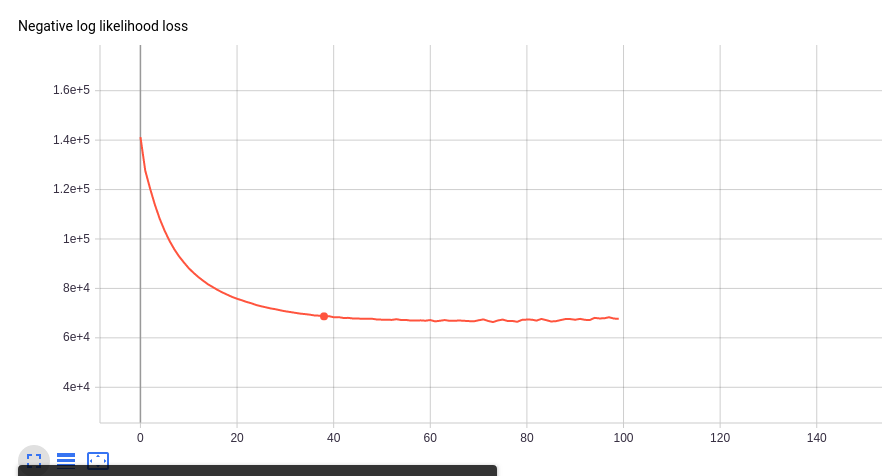

Ahora visualizamos que esta entregando el modelo entregado a grandes razgos.

In [83]:
ctx, target = ngrams[0]
ctx, target

(['TIMESHIFT<46>',
  'NOTE-ON<54>',
  'SET-VELOCITY<84>',
  'NOTE-ON<61>',
  'NOTE-ON<64>',
  'NOTE-ON<69>',
  'NOTE-ON<73>',
  'NOTE-ON<76>',
  'NOTE-ON<81>',
  'TIMESHIFT<1>',
  'NOTE-OFF<64>',
  'NOTE-OFF<69>',
  'TIMESHIFT<1>',
  'NOTE-OFF<54>',
  'NOTE-OFF<61>',
  'NOTE-OFF<81>',
  'TIMESHIFT<1>',
  'NOTE-OFF<73>',
  'NOTE-OFF<76>',
  'TIMESHIFT<49>',
  'NOTE-ON<30>',
  'SET-VELOCITY<87>',
  'NOTE-ON<57>',
  'TIMESHIFT<1>',
  'NOTE-ON<49>',
  'SET-VELOCITY<76>',
  'NOTE-ON<52>',
  'TIMESHIFT<5>',
  'NOTE-OFF<30>',
  'SET-VELOCITY<31>',
  'NOTE-ON<33>',
  'TIMESHIFT<3>',
  'NOTE-OFF<33>',
  'TIMESHIFT<1>',
  'NOTE-ON<30>',
  'SET-VELOCITY<65>',
  'TIMESHIFT<3>',
  'NOTE-OFF<30>',
  'TIMESHIFT<2>',
  'NOTE-ON<33>',
  'SET-VELOCITY<57>',
  'TIMESHIFT<1>',
  'NOTE-OFF<33>',
  'TIMESHIFT<2>',
  'NOTE-ON<30>',
  'SET-VELOCITY<63>',
  'TIMESHIFT<1>',
  'NOTE-OFF<30>',
  'TIMESHIFT<3>',
  'NOTE-ON<33>'],
 'SET-VELOCITY<60>')

In [85]:
ctx_idxs = torch.LongTensor([wrapper.token_to_idx[ctx_token] for ctx_token in ctx])
output = wrapper.model(ctx_idxs)
output

tensor([[-45.9219, -36.4198, -42.9546, -44.1666, -29.4348, -39.1468, -44.4702,
         -38.5215, -40.2162, -43.9466, -18.9177, -44.1042, -45.1652, -44.7139,
         -43.9391, -44.9579, -22.3625, -43.9659, -31.0093, -47.8223, -31.1965,
         -44.6998, -22.8103, -44.8979, -44.7211, -45.6897, -34.5872, -38.3241,
         -45.2252, -43.7289, -41.7300, -44.5299, -43.8730, -45.2871, -43.9739,
         -44.5313, -46.7078, -43.8783, -44.0304, -30.4000, -44.0511, -46.0704,
         -45.3262, -43.8577, -47.9519, -37.6636, -37.6721, -43.8019, -37.9727,
         -46.6063, -41.3014, -46.3314, -27.5693, -44.0976, -45.9660, -45.3657,
         -34.9595, -45.0220, -12.6208, -49.9018, -44.1389, -44.6400, -43.8305,
         -45.5143, -43.2183, -43.6054, -44.7669, -47.6195, -45.8334, -44.1613,
         -44.4373, -44.3405, -42.2371, -43.8006, -44.4821,  -5.5952, -44.1383,
         -44.1037, -46.2502, -43.3107, -43.9402, -57.4958, -24.3761, -42.3599,
         -43.2849, -46.3403, -31.6126, -15.9205, -44

In [88]:
output.sum()

tensor(-37637.1250, grad_fn=<SumBackward0>)

In [90]:
target_idx = torch.LongTensor([wrapper.token_to_idx[target]])
loss = wrapper.loss_function(output, target_idx)


In [91]:
loss

tensor(0.5193, grad_fn=<NllLossBackward>)

In [132]:
np.sum(output.detach().numpy())

-37637.133

In [115]:
histogram = np.exp(output.detach().numpy())
histogram.sum()

1.0

In [ ]:
histogram

In [103]:
import matplotlib.pyplot as plt

#### Output interpretado como softmax (el del modelo es una log softmax)

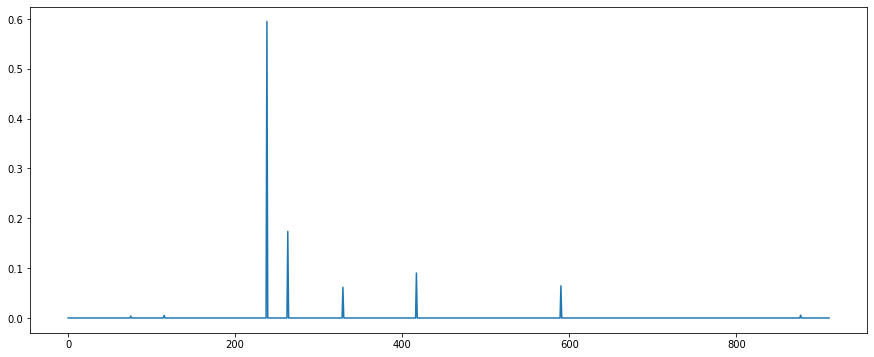

In [118]:
plt.figure(figsize=(15, 6))
plt.plot(list(range(len(histogram[0]))), histogram[0])
plt.show()

In [126]:
list(histogram[0]).index(histogram[0].max())

238

In [129]:
wrapper.token_to_idx[target]

238

In [130]:
target

'SET-VELOCITY<60>'

In [133]:
len(ngrams)

29898

In [144]:
- np.log(1) * 29897

-0.0

In [145]:
67000 / 29898

2.2409525720784

In [146]:
np.exp(- 67000 / 29898)

0.1063571432650211

In [152]:
-np.log(0.1) * 29898

68842.68911033597

In [ ]:
np.exp(-3.4)

# Visualize embedding

Hipotesis: Si el embedding esta funcionando, entonces debiese lograr agrupar las 4 categorias de tokens.

In [163]:
idxs_tensor = torch.LongTensor([wrapper.token_to_idx[token] for token in vocabulary])
embedded_vectors = wrapper.model.embeddings(idxs_tensor)
embedded_vectors

tensor([[-0.4993,  0.3026,  0.5478,  1.6950,  0.0227],
        [-0.1631, -0.5360, -0.7017, -0.6287, -0.1433],
        [ 3.4714, -1.0207,  1.6440, -1.0630, -0.5731],
        ...,
        [-1.8088,  0.1278, -0.5412, -0.4083, -0.8766],
        [-0.1532,  0.8389,  0.3404,  0.9869, -0.6706],
        [-0.3194,  0.1767,  2.5692, -1.4574,  1.0262]],
       grad_fn=<EmbeddingBackward>)

In [166]:
from sklearn.manifold import TSNE

In [168]:
embedded_2d = TSNE(n_components=2).fit_transform(embedded_vectors.detach().numpy())
embedded_2d.shape

(912, 2)

In [187]:
timeshift = []
velocity = []
note_on = []
note_off = []

for i, token in enumerate(vocabulary):
    if "TIMESHIFT" in token:
        timeshift.append(i)
    elif "VELOCITY" in token:
        velocity.append(i)
    elif "ON" in token:
        note_on.append(i)
    elif "OFF" in token:
        note_off.append(i)

timeshift_vectors = embedded_2d[timeshift]
velocity_vectors = embedded_2d[velocity]
note_on_vectors = embedded_2d[note_on]
note_off_vectors = embedded_2d[note_off]

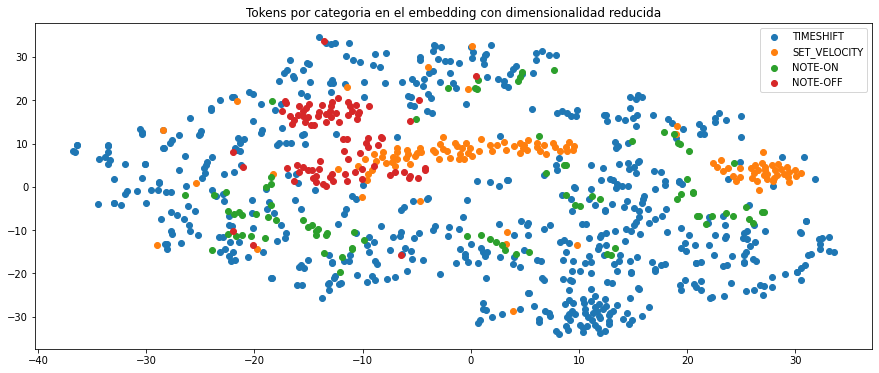

In [205]:
plt.figure(figsize=(15, 6))

plt.scatter(*timeshift_vectors.T, label="TIMESHIFT")
plt.scatter(*velocity_vectors.T, label="SET_VELOCITY")
plt.scatter(*note_on_vectors.T, label="NOTE-ON")
plt.scatter(*note_off_vectors.T, label="NOTE-OFF")

plt.title("Tokens por categoria en el embedding con dimensionalidad reducida")
plt.legend()
plt.show()

In [190]:
numbers = []
for i, token in enumerate(np.array(vocabulary)[timeshift]):
    numbers.append(int(token.split('<')[1].strip(">")))

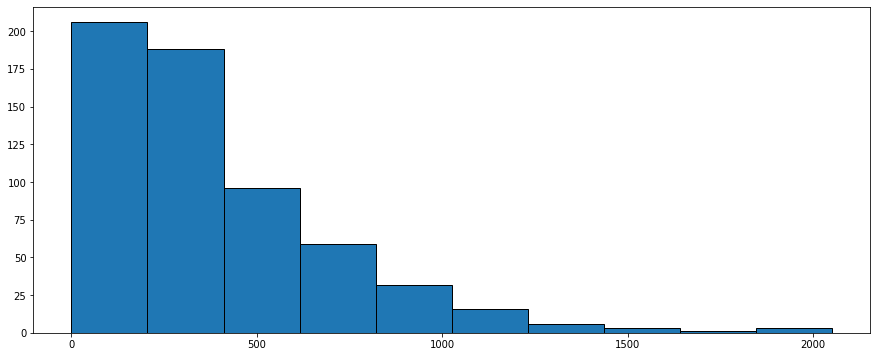

In [193]:
plt.figure(figsize=(15, 6))
plt.hist(numbers, edgecolor="black")
plt.show()

In [194]:
bins = [[], [], [], [], []]
for i, token in enumerate(np.array(vocabulary)[timeshift]):
    number = int(token.split('<')[1].strip(">"))
    
    if number < 200:
        bins[0].append(i)
    elif number < 400:
        bins[1].append(i)
    elif number < 600:
        bins[2].append(i)
    elif number < 800:
        bins[3].append(i)
    else:
        bins[4].append(i)

In [195]:
timeshift_bin0 = embedded_2d[timeshift][bins[0]]
timeshift_bin1 = embedded_2d[timeshift][bins[1]]
timeshift_bin2 = embedded_2d[timeshift][bins[2]]
timeshift_bin3 = embedded_2d[timeshift][bins[3]]
timeshift_bin4 = embedded_2d[timeshift][bins[4]]

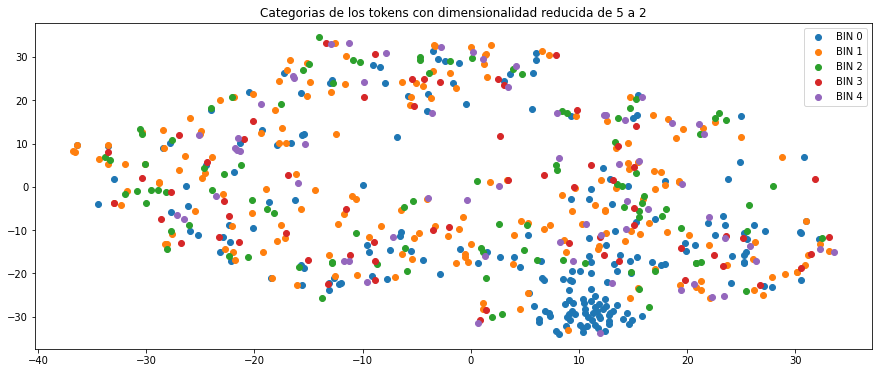

In [202]:
plt.figure(figsize=(15, 6))

plt.scatter(*timeshift_bin0.T, label="BIN 0")
plt.scatter(*timeshift_bin1.T, label="BIN 1")
plt.scatter(*timeshift_bin2.T, label="BIN 2")
plt.scatter(*timeshift_bin3.T, label="BIN 3")
plt.scatter(*timeshift_bin4.T, label="BIN 4")

plt.legend()
plt.show()

In [206]:
numbers = []
for i, token in enumerate(np.array(vocabulary)[velocity]):
    numbers.append(int(token.split('<')[1].strip(">")))

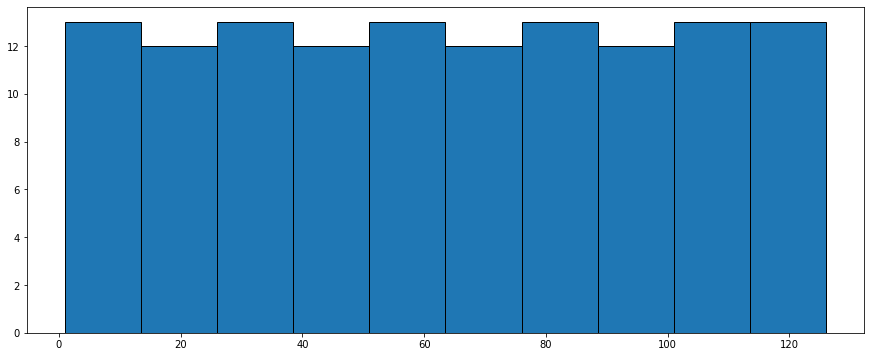

In [207]:
plt.figure(figsize=(15, 6))
plt.hist(numbers, edgecolor="black")
plt.show()

In [208]:
bins = [[], [], [], [], []]
for i, token in enumerate(np.array(vocabulary)[velocity]):
    number = int(token.split('<')[1].strip(">"))
    
    if number < 40:
        bins[0].append(i)
    elif number < 60:
        bins[1].append(i)
    elif number < 80:
        bins[2].append(i)
    elif number < 100:
        bins[3].append(i)
    else:
        bins[4].append(i)

In [209]:
velocity_bin0 = embedded_2d[velocity][bins[0]]
velocity_bin1 = embedded_2d[velocity][bins[1]]
velocity_bin2 = embedded_2d[velocity][bins[2]]
velocity_bin3 = embedded_2d[velocity][bins[3]]
velocity_bin4 = embedded_2d[velocity][bins[4]]

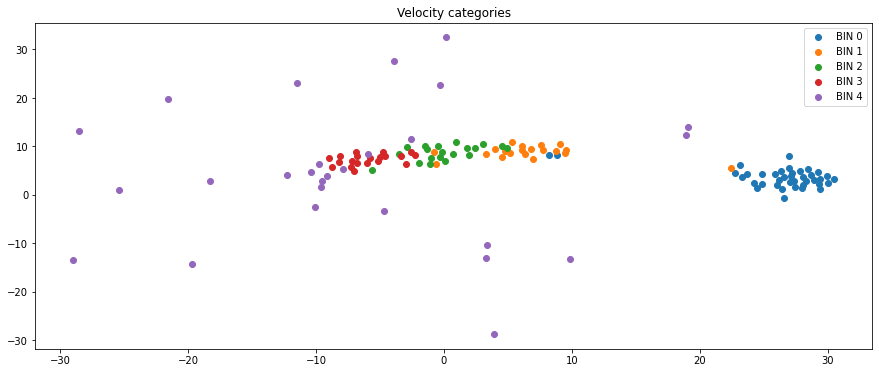

In [213]:
plt.figure(figsize=(15, 6))

plt.scatter(*velocity_bin0.T, label="BIN 0")
plt.scatter(*velocity_bin1.T, label="BIN 1")
plt.scatter(*velocity_bin2.T, label="BIN 2")
plt.scatter(*velocity_bin3.T, label="BIN 3")
plt.scatter(*velocity_bin4.T, label="BIN 4")

plt.title("Velocity categories")
plt.legend()
plt.show()

In [64]:
!rm -r logs/embedding1

In [76]:
!mkdir logs/embedding2

mkdir: cannot create directory ‘logs/embedding2’: File exists


In [77]:
!ls logs

embedding1  embedding2
